In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.patches import Patch
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'
# 設置微軟正黑體為全域字體
rcParams['font.family'] = 'Microsoft JhengHei'

In [3]:
# 讀取 Excel 檔案
file_path = "科中路6F-8Fmeter_21276307021_data.xlsx"
raw_data = pd.read_excel(file_path)
time_col = "時間"
usage_col = "用電總量"
default_drop_cols = ['儲冷尖峰', '儲冷半尖峰', '儲冷週六半尖峰', '儲冷離峰', '太陽光電']
raw_data.drop(columns=default_drop_cols, inplace=True, errors='ignore')
# 將時間欄位轉換為日期時間格式
raw_data[time_col] = pd.to_datetime(raw_data[time_col])

columns_to_sum = ['尖峰', '半尖峰', '週六半尖峰', '離峰']
raw_data[columns_to_sum] = raw_data[columns_to_sum] 
raw_data[usage_col] = raw_data[columns_to_sum].apply(
    lambda row: row.dropna().unique()[0]
    if row.nunique() == 1 else row.mode().iloc[0],
    axis=1)
raw_data = raw_data.drop(columns=columns_to_sum)

In [4]:
year_col = "年份"
month_col = "月份"
day_col = "日"
hour_col = "小時"
minute_col = "分鐘"
raw_data[year_col] = raw_data[time_col].dt.year
raw_data[month_col] = raw_data[time_col].dt.month
raw_data[day_col] = raw_data[time_col].dt.day
raw_data[hour_col] = raw_data[time_col].dt.hour
raw_data[minute_col] = raw_data[time_col].dt.minute
summary = raw_data.groupby([month_col,day_col, hour_col, minute_col])[usage_col].min().reset_index()
minimum_day_list =[]
for month in summary[month_col].unique():
    month_summary = summary[summary[month_col] == month]
    minimum_day = None
    for day in month_summary[day_col].unique():
        day_summary = month_summary[month_summary[day_col] == day]
        if minimum_day is None or minimum_day[usage_col].mean() > day_summary[usage_col].mean():
            minimum_day = day_summary
    minimum_day_list.append(minimum_day)


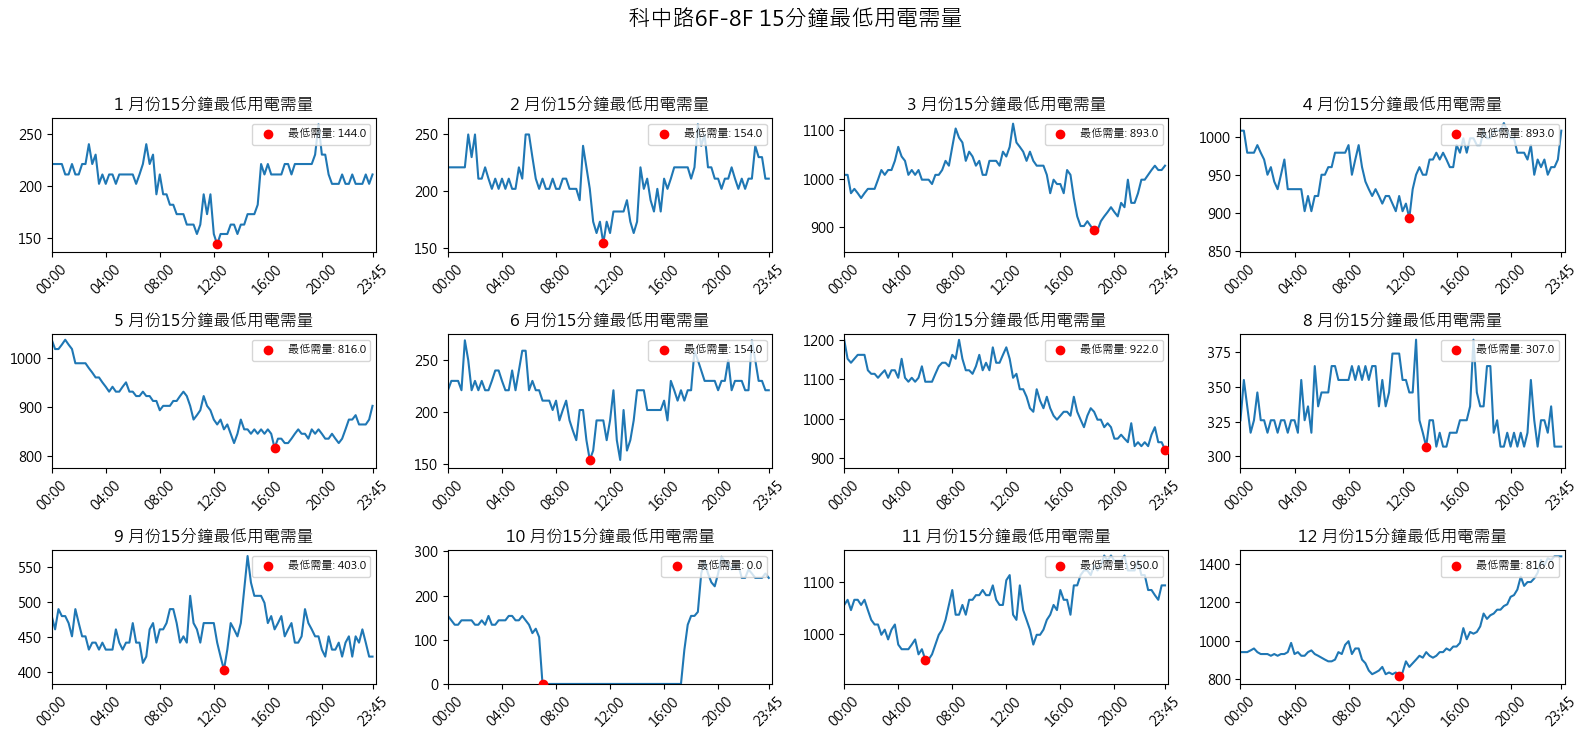

In [5]:

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 7))
for i, ax in enumerate(axes.flat):  # 使用 .flat 方便逐一訪問所有子圖
    time_labels = [f"{h:02d}:{m:02d}" for h, m in zip(minimum_day_list[i][hour_col], minimum_day_list[i][minute_col])]
    x = time_labels
    y = minimum_day_list[i][usage_col]

    y_minimum = y.min()
    x_idx = np.where(y == y.min())[0][0]  # 找到最小值的索引

    ax.plot(x, y)
    ax.scatter(x[x_idx], y_minimum, color='red', label=f'最低需量: {y_minimum}', zorder=5, )  # 標記最小值
    tick_positions = list(range(0, len(time_labels), 16))
    if len(time_labels) - 1 not in tick_positions:
        tick_positions.append(len(time_labels) - 1)  # 加入最後一個 `tick`

    ax.set_xticks(tick_positions)
    ax.set_xticklabels([time_labels[j] for j in tick_positions], rotation=45)
    ax.set_xlim(left=0, right=len(time_labels))  # X 軸從 0 開始
    ax.set_ylim(bottom=y_minimum*0.95)
    ax.set_title(f'{i+1} 月份15分鐘最低用電需量')
    ax.legend(loc='upper right', fontsize=8)
fig.suptitle('科中路6F-8F 15分鐘最低用電需量', fontsize=16, y=1.05)
# 調整子圖間距
plt.tight_layout()
plt.show()